In [1]:
import cairo
import math
import random
from IPython.display import SVG, display, Image

def show_img(file):
    display(Image(filename=file))

def get_pixel_pil(filename, xy):
    """
    Hijacking Pillow's get pixel function. Faster, but not accurate.  
    
    inputs:
        filename: image file  
        xy (tuple): target pixel location  
    
    output:
        RGB of pixel 
    """
    import PIL.Image as _pilimage
    im = _pilimage.open(fn)
    return im.getpixel(xy)

def get_pixel_pycairo(surface, xy):
    """
    Gets RGB/RGBA information at a pixel location for a given surface. 
    Slower than the PIL hijack, but works within a surface; no save necessary.
    
    inputs:
        surface: PyCairo surface  
        xy (tuple): pixel location  
        
    output:
        RGB or RGBA in list format (values: 0-255)
    """
    height_got = surface.get_height()
    width_got = surface.get_width()
    _data = surface.get_data().tolist()
    
    if surface.get_content() == cairo.Content.COLOR_ALPHA:
        ix_end=4
    else:
        ix_end=3

    ix_start=0
    ix_b = ix_start+(ix_end*xy[0])+((ix_end*width_got)*xy[1])
    ix_a = ix_b+3
    ix_g = ix_b+1
    ix_r = ix_b+2
        
    return _data[ix_r],_data[ix_g],_data[ix_b],_data[ix_a]

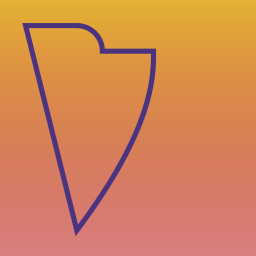

In [2]:
# example from https://pycairo.readthedocs.io/en/latest/tutorial.html

fn = "example.png"
WIDTH, HEIGHT = 256, 256

surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
ctx = cairo.Context(surface)

ctx.scale(WIDTH, HEIGHT)  # Normalizing the canvas

pat = cairo.LinearGradient(0.0, 0.0, 0.0, 1.0)
pat.add_color_stop_rgba(1, 0.7, 0, 0, 0.5)  # First stop, 50% opacity
pat.add_color_stop_rgba(0, 0.9, 0.7, 0.2, 1)  # Last stop, 100% opacity

ctx.rectangle(0, 0, 1, 1)  # Rectangle(x0, y0, x1, y1)
ctx.set_source(pat)
ctx.fill()

ctx.translate(0.1,0.1)  # Changing the current transformation matrix

ctx.move_to(0, 0)
ctx.arc(0.2, 0.1, 0.1, -math.pi/2, 0)
ctx.line_to(0.5, 0.1)  # Line to (x,y)
ctx.curve_to(0.5, 0.2, 0.5, 0.4, 0.2, 0.8)
ctx.close_path()

ctx.set_source_rgb(0.3, 0.2, 0.5)  # Solid color
ctx.set_line_width(0.02)
ctx.stroke()

surface.write_to_png(fn)  # Output to PNG
show_img(fn)

In [3]:
%%timeit
get_pixel_pil(fn, (0,0))

The slowest run took 20.50 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.63 ms per loop


In [4]:
%%timeit
get_pixel_pycairo(surface, (0,0))

100 loops, best of 3: 3.17 ms per loop


In [5]:
print('Location: (0,0)')
print(get_pixel_pil(fn, (0,0)))
print(get_pixel_pycairo(surface, (0,0)))
print()

random_x = random.randint(0,255)
random_y = random.randint(0,255)

print('Location: (' + str(random_x) + ', ' + str(random_y) + ')')
print(get_pixel_pil(fn, (random_x,random_y)))
print(get_pixel_pycairo(surface, (random_x,random_y)))


Location: (0,0)
(229, 178, 51, 255)
(229, 178, 51, 255)

Location: (4, 86)
(212, 118, 34, 212)
(176, 98, 28, 212)


In [6]:
def draw_line(context, loc_x,loc_y, angle, max_width):
    """
    draw rand line like in that one stream nw did!
    
    inputs:
        context: pycairo context
        loc_x: x location (pixels)
        loc_y: y location (pixels)  
        angle: angle (degrees)
        max_width: max line width possible
        
    output:
        a line on the canvas  
    
    Note: The line can start or end off the canvas  
        
    """
    
    line_length = random.randint(1,566)
    angle = random.randint(0,360)
    hue = angle/(angle+random.randint(0,360)) 
    context.set_source_rgb(angle/(angle+random.randint(0,360)), angle/(angle+random.randint(0,360)), angle/(angle+random.randint(0,360)))
    
    if not random.randint(0,20):
        context.set_source_rgb(0, 0, 0)
    
    context.set_line_width(random.randint(1,max_width))
    context.save()

    context.translate(xc,yc)
    context.rotate(angle*(math.pi/180)) # needs radians 
    context.translate(-xc,-yc)

    context.move_to(loc_x,loc_y-(line_length/2))
    context.line_to(loc_x,(loc_y-(line_length/2))+line_length)
    context.stroke()
    
def draw_circle(context,loc_x,loc_y, min_radius, max_lo_radius, 
                max_hi_radius, canvas_width, canvas_height, alpha):
    """
    draw rand circle like in that one stream nw did!
    
    inputs:
        context: pycairo context
        loc_x: x location (pixels)
        loc_y: y location (pixels)  
        min_radius: smallest circle radius possible  
        max_lo_radius: smallest "max" possible 
        max_hi_radius: largest "max" possible 
        canvas_width: canvas width max 
        canvas_height: canvas height max 
        
    output:
        a circle within the canvas bounds 
    
    Note: Circle does not expand beyond the given bounds
        
    """
    max_radius = random.randint(max_lo_radius,max_hi_radius)
    radius = random.randint(min_radius,max_radius)
    angle = random.randint(0,360)
    
    alpha_black = alpha + random.randrange(1,10)/100
    context.set_source_rgba(0,0,0,alpha_black)

    context.arc(loc_x, loc_y, radius+random.randint(1,20), 0, 2*math.pi)
    context.fill()

    context.set_source_rgb(1,1,1)
    context.arc(loc_x, loc_y, radius, 0, 2*math.pi)
    context.fill()

    context.set_source_rgba(angle/(angle+random.randint(0,360)), 
                            angle/(angle+random.randint(0,360)), 
                            angle/(angle+random.randint(0,360)), 
                            alpha)
    context.arc(loc_x, loc_y, radius, 0, 2*math.pi)
    context.fill()

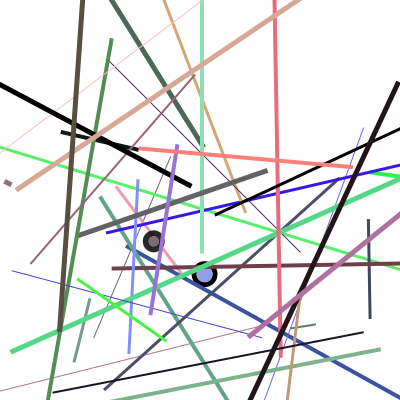

In [7]:
filename = "examplelines.png"

WIDTH = 400
HEIGHT = 400 
xc = WIDTH/2
yc = HEIGHT/2

surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
context = cairo.Context(surface)
context.set_source_rgb(1, 1, 1)
context.paint()

circles_appear = [random.randint(0,19), 
                  random.randint(0,19), 
                  random.randint(0,19)]

for ix in range(40):
    if ix in circles_appear:
        max_hi_radius=60
        loc_x = random.randint(0+(2*max_hi_radius),400-(2*max_hi_radius))
        loc_y = random.randint(0+(2*max_hi_radius),400-(2*max_hi_radius))
        
        draw_circle(context,loc_x,loc_y, min_radius=3, max_lo_radius=15, 
                    max_hi_radius=max_hi_radius, canvas_width=WIDTH, 
                    canvas_height=HEIGHT, alpha=random.randrange(40,100)/100)
   
    loc_x = random.randint(0,400)
    loc_y = random.randint(0,400)
    draw_line(context, loc_x, loc_y, random.randint(0,360), 5)

surface.write_to_png(filename)  # Output to PNG
show_img(filename)

In [8]:
print('Location: (0,0)')
print(get_pixel_pil(filename, (0,0)))
print(get_pixel_pycairo(surface, (0,0)))
print()
random_x = random.randint(0,255)
random_y = random.randint(0,255)

print('Location: (' + str(random_x) + ', ' + str(random_y) + ')')
print(get_pixel_pil(filename, (random_x,random_y)))
print(get_pixel_pycairo(surface, (random_x,random_y)))


Location: (0,0)
(229, 178, 51, 255)
(255, 255, 255, 255)

Location: (119, 24)
(225, 162, 46, 243)
(255, 255, 255, 255)
